# Monte Carlo Dispersion Analysis using MRS (Multivariable Rejection Sampling)

## Clone repository if using Google Colab

In [ ]:
!git clone https://github.com/Projeto-Jupiter/RocketPaper.git
import os
os.chdir('MRS')

## Initialization Cells

In [1]:
from datetime import datetime
import glob
import numpy as np
import IPython

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['figure.figsize'] = [8, 5]
mpl.rcParams['figure.dpi'] = 200
mpl.rcParams['font.size'] = 10
mpl.rcParams['legend.fontsize'] = 'medium'
mpl.rcParams['figure.titlesize'] = 'medium'
plt.style.use('science')

## Defining Analysis Parameters

In [3]:
analysis_parameters = {
    # Mass Details
    "rocketMass": (8.257, 0.001),
    
    # Propulsion Details
    "impulse": (1415.15, 35.3),
    "burnOut": (5.274, 1),
    "nozzleRadius": (21.642/1000, 0.5/1000),
    "throatRadius": (8/1000, 0.5/1000),
    "grainSeparation": (6/1000, 1/1000),
    "grainDensity": (1707, 50),
    "grainOuterRadius": (21.4/1000, 0.375/1000),
    "grainInitialInnerRadius": (9.65/1000, 0.375/1000),
    "grainInitialHeight": (120/1000, 1/1000),

    # Aerodynamic Details
    "inertiaI": (3.675, 0.03675),
    "inertiaZ": (0.007, 0.00007),
    "radius": (40.45/1000,0.001),
    "distanceRocketNozzle": (-1.024,0.001),
    "distanceRocketPropellant": (-0.571,0.001),
    #"powerOffDrag": (0.9081/1.05, 0.033),
    #"powerOnDrag": (0.9081/1.05, 0.033),
    "powerOffDrag": (1, 0.033),
    "powerOnDrag": (1, 0.033),
    "noseLength": (0.274, 0.001),
    "noseDistanceToCM": (1.134, 0.001),
    "finSpan": (0.077, 0.0005),
    "finRootChord": (0.058, 0.0005),
    "finTipChord": (0.018, 0.0005),
    "finDistanceToCM": (-0.906, 0.001),

    # Launch and Environment Details
    "windDirection":(0, 2),
    "windSpeed":(1, 0.033),
    "inclination": (84.7, 1),
    "heading": (53, 2),
    "railLength": (5.7 , 0.0005),
    #"ensembleMember": list(range(10)),
    
    # Parachute Details
    "CdSDrogue": (0.349*1.3, 0.07),
    "lag_rec": (1 , 0.5),
    
    # Electronic Systems Details
    "lag_se": (0.73, 0.16)}

## Importing Dispersion Analysis Saved Data

In [4]:
# Load data files
filename = 'valetudo_reanalysis'
dispersion_input_file = open(filename + '.valetudo_disp_in.txt')
dispersion_output_file = open(filename + '.valetudo_disp_out.txt')

# Initialize variable to store all loaded data
dispersion_inputs = {
    "rocketMass": [],
    # Propulsion Details
    "impulse": [],
    "burnOut": [],
    "nozzleRadius": [],
    "throatRadius": [],
    "grainSeparation": [],
    "grainDensity": [],
    "grainOuterRadius": [],
    "grainInitialInnerRadius": [],
    "grainInitialHeight": [],
    # Aerodynamic Details
    "inertiaI": [],
    "inertiaZ": [],
    "radius": [],
    "distanceRocketNozzle": [],
    "distanceRocketPropellant": [],
    #"powerOffDrag": [],
    #"powerOnDrag": [],
    "powerOffDrag": [],
    "powerOnDrag": [],
    "noseLength": [],
    "noseDistanceToCM": [],
    "finSpan": [],
    "finRootChord": [],
    "finTipChord": [],
    "finDistanceToCM": [],
    # Launch and Environment Details
    "windDirection": [],
    "windSpeed": [],
    "inclination": [],
    "heading": [],
    "railLength": [],
    # "ensemble_member": [],
    # Parachute Details
    "CdSDrogue": [],
    "lag_rec": [],
    # Electronic Systems Details
    "lag_se": [],
}

dispersion_outputs = {
    "outOfRailTime": [],
    "outOfRailVelocity": [],
    "apogeeTime": [],
    "apogeeAltitude": [],
    "apogeeX": [],
    "apogeeY": [],
    "impactTime": [],
    "impactX": [],
    "impactY": [],
    "impactVelocity": [],
    "initialStaticMargin": [],
    "outOfRailStaticMargin": [],
    "finalStaticMargin": [],
    "numberOfEvents": [],
    "maxVelocity": [],
    "drogueTriggerTime": [],
    "drogueInflatedTime": [],
    "drogueInflatedVelocity": []
}

# Read each line of the file and convert to dict
for line in dispersion_input_file:
    if line[0] == '{':
        flight_result = eval(line)
        for parameter_key, parameter_value in flight_result.items():
            if parameter_key == 'ensemble_member':
                continue
            dispersion_inputs[parameter_key].append(parameter_value)
for line in dispersion_output_file:
    if line[0] == '{':
        flight_result = eval(line)
        for parameter_key, parameter_value in flight_result.items():
            dispersion_outputs[parameter_key].append(parameter_value)

# Close data files
dispersion_input_file.close()
dispersion_output_file.close()

# Print number of flights simulated
N_input = len(dispersion_inputs["rocketMass"])
N = len(dispersion_outputs["outOfRailTime"])
print('Number of simulations in input: ', N_input)
print('Number of simulations in input: ', N)

Number of simulations in input:  19300
Number of simulations in input:  19300


## Defining MRS Alogrithm

In [5]:
import scipy
import scipy.stats
from scipy.stats import multivariate_normal, norm, uniform, normaltest, gaussian_kde
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd

In [6]:
def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, h

def test_if_gaussian(filtered_samples):
    #Test if filtered samples obey new_pdfs
    all_gaussian = True
    number_of_samples, number_of_variables = filtered_samples.shape
    
    for j in range(number_of_variables):
        # Test results
        k2, p = normaltest(filtered_samples[:, j])
        
        # null hypothesis: x comes from a normal distribution
        alpha = 1e-3
        if p < alpha: 
            # print("The null hypothesis can be rejected")
            all_gaussian = False
            
    return all_gaussian

def test_if_gaussian_single(filtered_samples):
    #Test if filtered samples obey new_pdfs
    gaussian = True
    # Test results
    k2, p = normaltest(filtered_samples)

    # null hypothesis: x comes from a normal distribution
    alpha = 1e-3
    if p < alpha: 
        # print("The null hypothesis can be rejected")
        gaussian = False
            
    return gaussian

def is_outlier(points, thresh=3.5):
    """
    Returns a boolean array with True if points are outliers and False 
    otherwise.

    Parameters:
    -----------
        points : An numobservations by numdimensions array of observations
        thresh : The modified z-score to use as a threshold. Observations with
            a modified z-score (based on the median absolute deviation) greater
            than this value will be classified as outliers.

    Returns:
    --------
        mask : A numobservations-length boolean array.

    References:
    ----------
        Boris Iglewicz and David Hoaglin (1993), "Volume 16: How to Detect and
        Handle Outliers", The ASQC Basic References in Quality Control:
        Statistical Techniques, Edward F. Mykytka, Ph.D., Editor. 
    """
    if len(points.shape) == 1:
        points = points[:,None]
    median = np.median(points, axis=0)
    diff = np.sum((points - median)**2, axis=-1)
    diff = np.sqrt(diff)
    med_abs_deviation = np.median(diff)

    modified_z_score = 0.6745 * diff / med_abs_deviation

    return modified_z_score > thresh

In [7]:
def multivariate_rejection_sampling(old_pdfs, new_pdfs, samples, all_guassian=False):
    """ Applies Successive Rejection Sampling to fictious inputs of a Monte Carlo Analysis.
    
    Parameters
    ----------
    old_pdfs : list of continous random variables ([scipy.stats.rv_continuous])
        List of probability density functions used to generate inputs of a Monte Carlo analysis.
        Example: [norm(loc=0, scale=1), norm(loc=1, scale=1), uniform(loc=-0.5, scale=1.0)]
    new_pdfs : list of continous random variables ([scipy.stats.rv_continuous])
        List of new probability density functions for which you want the results of a Monte Carlo analysis.
        Order is important. Mantain the same order as old_pdfs.
        Example: [norm(loc=0.5, scale=0.5), norm(loc=1, scale=0.8), uniform(loc=-0.4, scale=0.8)]
    samples : np.array, int
        Array with all the inputs generated for the Monte Carlo analysis with old_pdfs.
        Can also be an int. If it is an int, the function creates a sample of inputs based on old_pdfs with the size
        being specified by the int.
    all_guassian : bool, optional
        Specifies if all the pdfs given are normal pdfs. If this is the case, the results are
        checked to make sure SRS is working. Default is False.  
    
    Returns
    -------
    filtered_indices : np.array
        Array which gives the indices of all the inputs and outputs iterations of the Monte Carlos
        analysis which sould be considered to get the results for the new_pdfs as inputs.
    filtered_samples : np.array
        Filtered inputs
    """
    
    # Initialize samples
    if isinstance(samples, int):
        # Generate old distribution
        samples = np.zeros((samples, number_of_variables))
        for j, pdf in enumerate(old_pdfs):
            samples[:, j] = pdf.rvs(number_of_samples)
    if isinstance(samples, pd.DataFrame):
        samples_dataframe = samples
        samples = samples.to_numpy()
      
    number_of_samples, number_of_variables = samples.shape
    
    # Calculate coefficients Ms
    M = []
    for j in range(number_of_variables):
        # Calculate M
        x_mesh = samples[:, j]
        M += [np.max(new_pdfs[j].pdf(x_mesh)/old_pdfs[j].pdf(x_mesh))]
        
    # Calculate filtering probability
    dont_filter_probability = np.ones((number_of_samples,))
    for j in range(number_of_variables):
        variable_values = samples[:, j]
        dont_filter_probability *= new_pdfs[j].pdf(variable_values)/(M[j]*old_pdfs[j].pdf(variable_values))
        
    # Roll the "gimmick" dice
    test = dont_filter_probability - uniform.rvs(size=number_of_samples)
    filtered_samples = samples[np.where(test > 0)]
    
    # Plot and print results
    number_of_filtered_samples = len(filtered_samples)
    print('Final data set size: ', 100*number_of_filtered_samples/number_of_samples, '% of', str(number_of_samples) + '.')
    
    if all_guassian:
        print('Works:', test_if_gaussian(filtered_samples))
        
    filtered_indices = np.where(test > 0)
    return filtered_indices, filtered_samples

## Running MRS

In [21]:
# Inputs:
#  analysis_parameters
#  dispersion_inputs
#  dispersion_outputs

input_dataframe = pd.DataFrame.from_dict(dispersion_inputs)
output_dataframe = pd.DataFrame.from_dict(dispersion_outputs)

# Form old pdfs
old_pdfs = []
for parameter_key, parameter_value in analysis_parameters.items():
    old_pdfs += [norm(loc=parameter_value[0], scale=parameter_value[1])]

new_pdfs = old_pdfs[:]
# Change inclination
new_pdfs[-6] = norm(85, 1)
# Change heading
new_pdfs[-5] = norm(53, 1.5)

# Perform SRS
filtered_indices, filtered_samples = multivariate_rejection_sampling(old_pdfs, new_pdfs, input_dataframe, all_guassian=True)

# Get filtered inputs and outputs
filtered_inputs_dataframe = input_dataframe.iloc[filtered_indices[0]]
filtered_outputs_dataframe = output_dataframe.iloc[filtered_indices[0]]

Final data set size:  21.849740932642487 % of 19300.
Works: True


## Results

Done


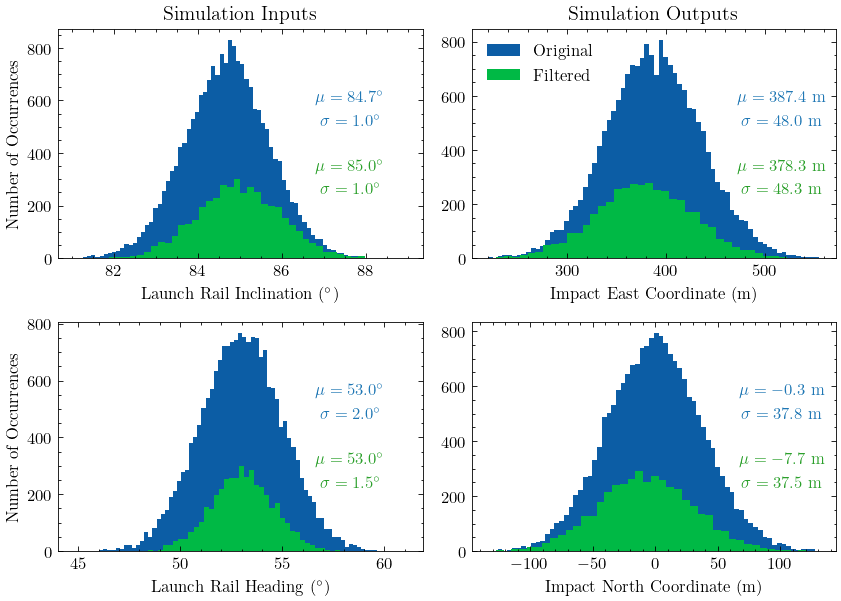

In [29]:
num_lines = 2

input_plots = {
    "rocketMass": False, # "Rocket Dry Mass (kg)",
    # Propulsion Details
    "impulse": False, # "Motor Impulse (Ns)",
    "burnOut": False,
    "nozzleRadius": False,
    "throatRadius": False,
    "grainSeparation": False,
    "grainDensity": False,
    "grainOuterRadius": False,
    "grainInitialInnerRadius": False,
    "grainInitialHeight": False,
    # Aerodynamic Details
    "inertiaI": False,
    "inertiaZ": False,
    "radius": False,
    "distanceRocketNozzle": False,
    "distanceRocketPropellant": False,
    #"powerOffDrag": False,
    #"powerOnDrag": False,
    "powerOffDrag": False,
    "powerOnDrag": False,
    "noseLength": False,
    "noseDistanceToCM": False,
    "finSpan": False,
    "finRootChord": False,
    "finTipChord": False,
    "finDistanceToCM": False,
    # Launch and Environment Details
    "windDirection": False,
    "windSpeed": False,
    "inclination": "Launch Rail Inclination ($^{\circ}$)",
    "heading": "Launch Rail Heading ($^{\circ}$)",
    "railLength": False,
    # "ensemble_member": False,
    # Parachute Details
    "CdSDrogue": False,
    "lag_rec": False,
    # Electronic Systems Details
    "lag_se": False
}

output_plots = {
    "outOfRailTime": False,
    "outOfRailVelocity": False,
    "apogeeTime": False,
    "apogeeAltitude": False, # "Apogee Altitude - AGL (m)",
    "apogeeX": False,
    "apogeeY": False,
    "impactTime": False,
    "impactX": "Impact East Coordinate (m)",
    "impactY": "Impact North Coordinate (m)",
    "impactVelocity": False,
    "initialStaticMargin": False,
    "outOfRailStaticMargin": False,
    "finalStaticMargin": False,
    "numberOfEvents": False,
    "maxVelocity": False, # "Maximum Velocity",
    "drogueTriggerTime": False,
    "drogueInflatedTime": False,
    "drogueInflatedVelocity": False
}

number_of_input_variables = len(input_dataframe.columns)
number_of_output_variables = len(output_dataframe.columns)

fig = plt.figure(figsize=(7, 2.5*num_lines), dpi=120, constrained_layout=True)
gs = fig.add_gridspec(num_lines, 2)

# Plot inputs
i = 0
for variable_name, values in input_dataframe.iteritems():
    if input_plots[variable_name]:
        filtered_values = values[filtered_indices[0]]
        ax = fig.add_subplot(gs[i, 0])
        ax.hist(values, 'fd', label='Original')
        ax.hist(filtered_values, 'fd', label='Filtered')
        ax.text(0.8, 0.7,
            f'$\\mu={np.mean(values):0.1f}^{{\\circ}}$',
            horizontalalignment='center', verticalalignment='center', transform=ax.transAxes, fontweight='bold', color='tab:blue'
        )
        ax.text(0.8, 0.6,
            f'$\\sigma={np.std(values):0.1f}^{{\\circ}}$',
            horizontalalignment='center', verticalalignment='center', transform=ax.transAxes, fontweight='bold', color='tab:blue'
        )
        ax.text(0.8, 0.4,
            f'$\\mu={np.mean(filtered_values):0.1f}^{{\\circ}}$',
            horizontalalignment='center', verticalalignment='center', transform=ax.transAxes, fontweight='bold', color='tab:green'
        )
        ax.text(0.8, 0.3,
            f'$\\sigma={np.std(filtered_values):0.1f}^{{\\circ}}$',
            horizontalalignment='center', verticalalignment='center', transform=ax.transAxes, fontweight='bold', color='tab:green'
        )
        # x_mesh = np.linspace(np.min(values), np.max(values), 200)
        # ax.plot(x_mesh, gaussian_kde(values)(x_mesh), fontweight='bold', color='tab:blue', label='Original')
        # ax.plot(x_mesh, gaussian_kde(filtered_values)(x_mesh), color='r', label='SRS result')
        ax.set_xlabel(input_plots[variable_name])
        ax.set_ylabel('Number of Occurrences')
        # ax.legend(loc=1)
        if i == 0:
            ax.set_title('Simulation Inputs')
        i += 1

# Plot outputs
i = 0
for variable_name, values in output_dataframe.iteritems():
    if output_plots[variable_name]:
        filtered_values = values[filtered_indices[0]]
        ax = fig.add_subplot(gs[i, 1])
        ax.hist(values[~is_outlier(values)], 'fd', label='Original')
        ax.hist(filtered_values[~is_outlier(filtered_values)], 'fd', label='Filtered')
        ax.text(0.85, 0.7,
            f'$\\mu={np.mean(values[~is_outlier(values)]):0.1f}$ m',
            horizontalalignment='center', verticalalignment='center', transform=ax.transAxes, fontweight='bold', color='tab:blue'
        )
        ax.text(0.85, 0.6,
            f'$\\sigma={np.std(values[~is_outlier(values)]):0.1f}$ m',
            horizontalalignment='center', verticalalignment='center', transform=ax.transAxes, fontweight='bold', color='tab:blue'
        )
        ax.text(0.85, 0.4,
            f'$\\mu={np.mean(filtered_values[~is_outlier(filtered_values)]):0.1f}$ m',
            horizontalalignment='center', verticalalignment='center', transform=ax.transAxes, fontweight='bold', color='tab:green'
        )
        ax.text(0.85, 0.3,
            f'$\\sigma={np.std(filtered_values[~is_outlier(filtered_values)]):0.1f}$ m',
            horizontalalignment='center', verticalalignment='center', transform=ax.transAxes, fontweight='bold', color='tab:green'
        )
        # x_mesh = np.linspace(np.min(values), np.max(values), 200)
        # ax.plot(x_mesh, gaussian_kde(values)(x_mesh), color='b', label='Original')
        # ax.plot(x_mesh, gaussian_kde(filtered_values)(x_mesh), color='r', label='SRS result')
        ax.set_xlabel(output_plots[variable_name])
        if i == 0:
            ax.set_title('Simulation Outputs')
            ax.legend(loc=2)
        i += 1

print('Done')
plt.savefig('MRS_results.pdf')  
plt.show()

In [30]:
for variable_name, values in output_dataframe.iteritems():
    if output_plots[variable_name]:
        filtered_values = values[filtered_indices[0]]
        print(mean_confidence_interval(values, confidence=0.999))
        print(mean_confidence_interval(filtered_values, confidence=0.999))

(387.41544148404876, 1.1424650079735257)
(378.203442299855, 2.4584313291391124)
(-0.21956565235608472, 0.9038192761562976)
(-7.641151927944785, 1.9098390441153692)


In [ ]:
for variable_name, values in output_dataframe.iteritems():
    filtered_values = np.array(values[filtered_indices[0]])
    print(variable_name, ':', test_if_gaussian_single(filtered_values))
    print('Mean:', np.mean(filtered_values), '| Std:', np.std(filtered_values))


outOfRailTime : True
Mean: 1.0838162951862902 | Std: 0.18801649615642996
outOfRailVelocity : False
Mean: 23.10390847713462 | Std: 3.1924597881632573
apogeeTime : False
Mean: 14.314225839573236 | Std: 0.35357424453301844
apogeeAltitude : True
Mean: 847.2612864988338 | Std: 43.58654649210127
apogeeX : True
Mean: 97.22722541213119 | Std: 24.61485231640024
apogeeY : True
Mean: 102.25976949710646 | Std: 19.67210459398819
impactTime : False
Mean: 63.03346629333131 | Std: 4.260602780395271
impactX : True
Mean: 374.7961891291166 | Std: 48.73433568883495
impactY : False
Mean: -9.861698017924292 | Std: 37.93713882746361
impactVelocity : False
Mean: -18.266708736470665 | Std: 2.199061072656426
initialStaticMargin : False
Mean: 1.9921068180402426 | Std: 0.3262296346349559
outOfRailStaticMargin : False
Mean: 2.1728399973370247 | Std: 0.3296009282772833
finalStaticMargin : False
Mean: 3.0201787420307338 | Std: 0.34571378291832056
numberOfEvents : True
Mean: 1.0 | Std: 0.0
maxVelocity : True
Mean: 12